<a href="https://colab.research.google.com/github/pachterlab/FGP_2023/blob/main/loci_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
from numpy import matlib
import scipy.stats
from numpy.random import random

import itertools

import numba
import tqdm
import multiprocessing
import scipy
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn
import pandas as pd

from scipy.stats import gaussian_kde as kde

# !pip --quiet install 'matplotlib==3.6.0'

import pkg_resources
# pkg_resources.require("matplotlib==3.6.0")
import matplotlib

from matplotlib.colors import Normalize
from matplotlib import cm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%config InlineBackend.figure_format = 'retina'

# ! pip install scanpy
import time
t1 = time.time()
import scanpy

In [11]:
## Read-in count matrix, output of snATAK pipeline, cells_x_genes.mtx
# Count matrix is in form cell:peak:count
gene_matrix_file = '/content/drive/MyDrive/Colab Notebooks/FGP_2023/human_mouse_mixture/cells_x_genes.mtx'
matrix_dimension = pd.read_csv(gene_matrix_file, ' ' ,nrows=1, skiprows=3, skipinitialspace=True, header=None)
matrix_dimension = matrix_dimension.values[0]
cell_number, site_number, count_number = [int(i) for i in matrix_dimension[0:3]]
print(cell_number, 'Cells')
print(site_number, 'Sites')
print(count_number, 'Non-zero Matrix Entries')

# (Could find cell barcodes in cells_x_genes.barcodes.txt.)

# Create dataframe with ATAC data.
df_atac = pd.read_csv (gene_matrix_file, sep=' ', skiprows=4, skipinitialspace=True, header=None)
df_atac.columns = ['Cell', 'Gene', 'Count']

<ipython-input-11-2fcc72e07f6f>:19: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_transcripts = pd.read_csv (transcript_file, '\t', skiprows=0, skipinitialspace=True, header=None)


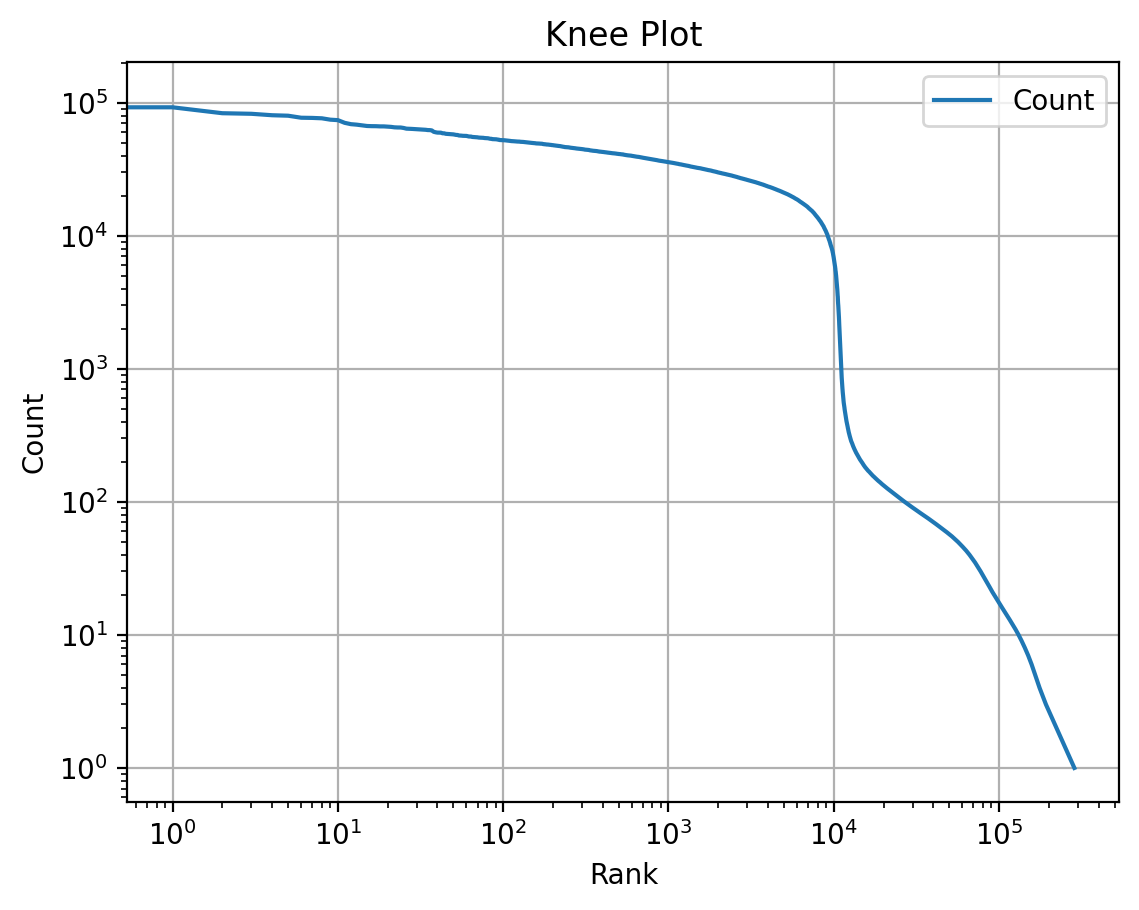

In [13]:
## Peform QC to remove cells with low number of reads.
cell_totals  = df_atac[['Cell', 'Count']].groupby("Cell").sum()

# Define your series
s = pd.Series(cell_totals['Count'], name='Count')
knee_df = pd.DataFrame(s)

# Frequency
stats_df = knee_df \
.groupby('Count') \
['Count'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'Count': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] #/ sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df['rank'] = stats_df['cdf'].iloc[-1] - stats_df['cdf']
stats_df = stats_df.reset_index()

## Create knee plot to identify UMI threshold.

stats_df.plot(x = 'rank', y = 'Count', grid = True, logx=True, logy=True)
plt.title('Knee Plot');
plt.xlabel('Rank')
plt.ylabel('Count')
plt.savefig('hi_' + out)

In [88]:
# Define UMI threshold at knee, and identify high quality cells.
UMI_threshold = 2000
high_cells = cell_totals[cell_totals['Count']>=UMI_threshold]
cell_num = len(high_cells)

print('Estimated High-quality number of cells', cell_num)
print('Median Fragments overlapping peaks per Cell', high_cells['Count'].median())

# Create filtered count matrix with high quality cells.
QC_df_atac = df_atac[df_atac['Cell'].isin(high_cells.index)]

Estimated High-quality number of cells 10820
Median Fragments overlapping peaks per Cell 20146.5


In [37]:
QC_df_atac

,Cell,Gene,Count
450,44,709,1
451,44,3309,1
452,44,3950,1
453,44,6839,1
454,44,7819,1
...,...,...,...
104158605,433968,98707,1
104158606,433968,98731,2
104158607,433968,99267,1
104158608,433968,99431,1


In [16]:
def test_close(a,b,distance):
    '''
    Test whether peak-sites a and b are closer than a given distance.

    Args:
        a (string): first peak-site, in form chrom:pos1-pos2 (e.g. 1:10003-10460)
        b (string): second peak-site, in form chrom:pos1-pos2 (e.g. 1:10003-10460)
        distance (float): distance threshold in bp

    Output:
        bool: whether or not peaks a and b are separated by at most this distance.
    '''

    chromosome_a, position_a = a.split(':')
    chromosome_b, position_b = b.split(':')

    if chromosome_a != chromosome_b:
        return False

    a_start, a_end = int(position_a.split('-')[0]), int(position_a.split('-')[1])
    b_start, b_end = int(position_b.split('-')[0]), int(position_b.split('-')[1])

    if b_start - a_end <= distance:
        return True
    else:
        return False

In [63]:
## Identify loci where 6 contiguous ATAC peaks are close.

# Create dataframe mapping each transcript to a genomic location.
transcript_file = '/content/drive/MyDrive/Colab Notebooks/FGP_2023/human_mouse_mixture/transcripts_hum_mouse_mixture.txt'
df_transcripts = pd.read_csv (transcript_file, sep='\t', skiprows=0, skipinitialspace=True, header=None)
df_transcripts.columns = ['location']
df_transcripts.index.name = 'transcript'
df_transcripts.index = df_transcripts.index+1

# Note the transcript indices where adjacent the following peak is less than 1.5 kbp away.
distance_threshold = 1500
df_transcripts['close']=0
for transcript in df_transcripts.index[:-1]:
    a= df_transcripts.loc[transcript]['location']
    b = df_transcripts.loc[transcript+1]['location']
    df_transcripts.at[transcript,'close'] = test_close(a,b,distance_threshold)
df_transcripts['close'].iloc[-1] = 0

# Find continguous loci of at least length 6.
loci_dfs = []
new_locus = pd.DataFrame(columns=['transcript', 'location', 'close'])
n_locus = 0

for i in df_transcripts.index:
    if df_transcripts['close'].loc[i]:
        n_locus += 1
        row = df_transcripts.loc[i]
        new_locus.loc[len(new_locus.index)] = [i, row[0], row[1]]
    else:
        if n_locus>=6:
            loci_dfs += [new_locus]
        new_locus = pd.DataFrame(columns=['transcript', 'location', 'close'])
        n_locus = 0

# Create a list of len(6) loci.
len6_loci = [i for i in loci_dfs if len(i)==6]
loci_transcripts = [i['transcript'].values for i in len6_loci]

# Create a list of all sites which are in one of the loci.
relevant_sites = np.concatenate(loci_transcripts).tolist()

KeyboardInterrupt: ignored

In [38]:
# Only retain sparse matrix entries from high quality cells at relevant sites.
QC_relevant = QC_df_atac[QC_df_atac['Gene'].isin(relevant_sites)]

In [76]:
## For multiple species, uncomment the following code to assign organisms to each cell and identify doublets.

# # Plot UMI numbers per cell
# high_cells.at[:,'num_human'] = 0
# high_cells.at['num_mouse'] = 0
# high_cells.at['organism'] = 0
# high_cells.at['ratio'] = 0

high_cells['num_human'] = 0
high_cells['num_mouse'] = 0
high_cells['organism'] = 0
high_cells['ratio'] = 0

# Assume transcripts are in order: human then mouse.
# Find first occurrence of mouse transcript.
# ! grep -m1 -n 'm' $transcript_file
first_mouse_line = 58016
for cell in high_cells.index:

    hum_mask = (QC_df_atac['Cell']==cell) & (QC_df_atac['Gene']<first_mouse_line)
    hum_genes = QC_df_atac[hum_mask]
    num_human = sum(hum_genes['Count'].values)
    high_cells.loc[cell, 'num_human'] = num_human
    mouse_mask = (QC_df_atac['Cell']==cell) & (QC_df_atac['Gene']>=first_mouse_line)
    mouse_genes = QC_df_atac[mouse_mask]
    num_mouse = sum(mouse_genes['Count'].values)
    high_cells.loc[cell, 'num_mouse'] = num_mouse
    if num_mouse > num_human:
        high_cells.loc[cell, 'organism'] = 'mouse'
        ratio = num_mouse/num_human
        high_cells.loc[cell, 'ratio'] = ratio

    elif num_human > num_mouse:
        high_cells.loc[cell, 'organism'] = 'human'
        ratio = num_human/num_mouse
        high_cells.loc[cell, 'ratio'] = num_human/num_mouse

    else:
        high_cells.loc[cell, 'organism'] = 'ambiguous'

    # Assign value ambiguous to organism if ratio
    if ratio < 5:
        high_cells.loc[cell, 'organism'] = 'ambiguous'
    # print(genes)
    # num_human = len(genes.values[genes.values<first_mouse_line])
    # num_mouse = len(genes.values[genes.values>=first_mouse_line])


<ipython-input-76-4e7d5bee5d02>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_cells['num_human'] = 0
<ipython-input-76-4e7d5bee5d02>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_cells['num_mouse'] = 0
<ipython-input-76-4e7d5bee5d02>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [81]:
## Assign doublets to 'ambiguous'

# Flag doublets by checking ratio between organism counts is high enough.
high_cells['ratio'] = high_cells['num_mouse']/high_cells['num_human']
high_cells['organism'][(high_cells['ratio'] < 1)] = 'human'
high_cells['organism'][(high_cells['ratio'] > 1)] = 'mouse'

ratio_threshold = 10
high_cells['organism'][(high_cells['ratio'] < ratio_threshold) & (high_cells['ratio'] > 1/ratio_threshold)] = 'ambiguous'

<ipython-input-81-451dbf6eff90>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_cells['ratio'] = high_cells['num_mouse']/high_cells['num_human']
<ipython-input-81-451dbf6eff90>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_cells['organism'][(high_cells['ratio'] < 1)] = 'human'
<ipython-input-81-451dbf6eff90>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_cell

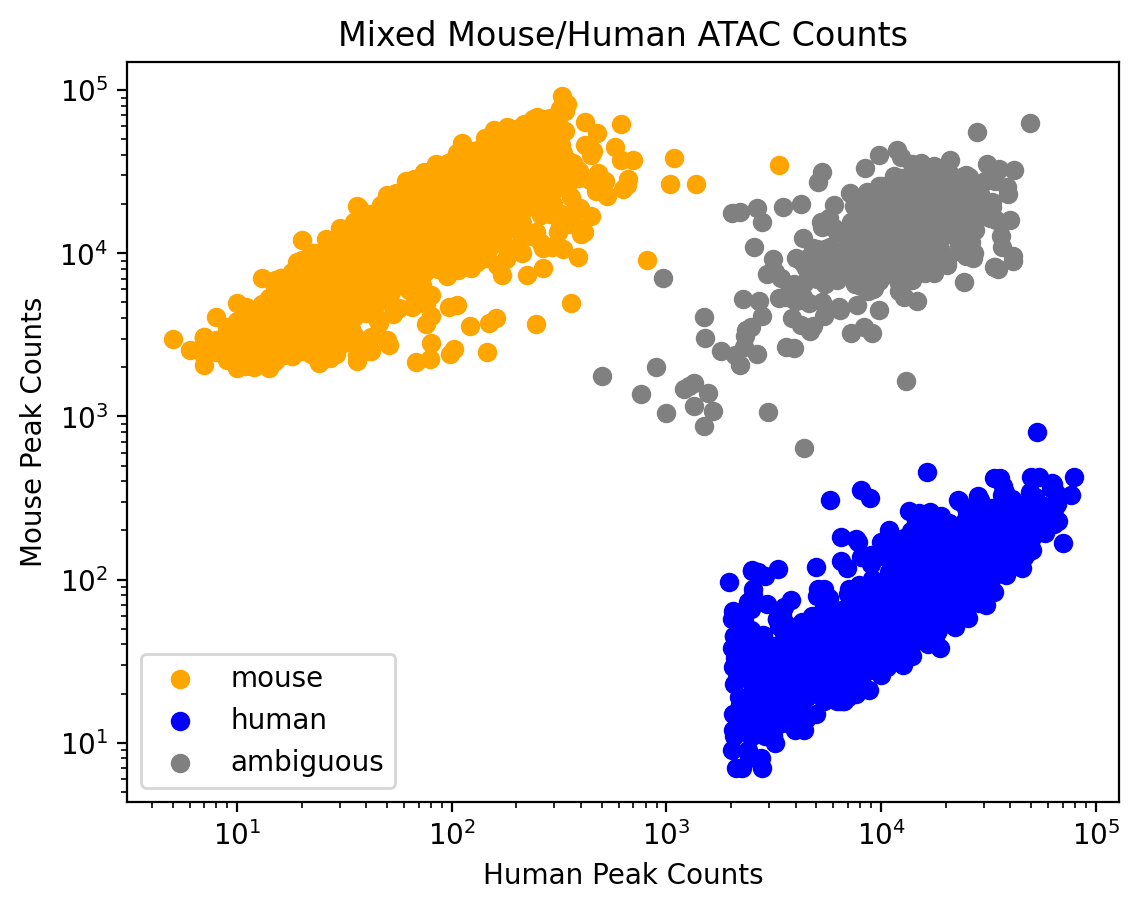

In [82]:
## Plot cells from each organism and doublets.

# Your data
col_dict = {'mouse': 'orange', 'human': 'blue', 'ambiguous': 'grey'}
colors = [col_dict[i] for i in high_cells['organism']]

# Separate the data into 'mouse' and 'human' and create scatter plots with labels
mouse_indices = high_cells['organism'] == 'mouse'
human_indices = high_cells['organism'] == 'human'
ambig_indices = high_cells['organism'] == 'ambiguous'


plt.scatter(high_cells['num_human'][mouse_indices], high_cells['num_mouse'][mouse_indices], c='orange', label='mouse')
plt.scatter(high_cells['num_human'][human_indices], high_cells['num_mouse'][human_indices], c='blue', label='human')
plt.scatter(high_cells['num_human'][ambig_indices], high_cells['num_mouse'][ambig_indices], c='grey', label='ambiguous')


plt.title('Mixed Mouse/Human ATAC Counts')
plt.xlabel('Human Peak Counts')
plt.ylabel('Mouse Peak Counts')
plt.xscale('log')
plt.yscale('log')

plt.legend()

In [83]:
## Create separate dataframes for each organism for all high quality cells, saving only relevant genes.

# Extract cell numbers from the index of high_cells
mouse_cell_numbers = high_cells[mouse_indices].index
human_cell_numbers = high_cells[human_indices].index

# Filter rows in QC_df_atac based on cell numbers
mouse_df = QC_relevant[QC_relevant['Cell'].isin(mouse_cell_numbers)]
human_df = QC_relevant[QC_relevant['Cell'].isin(human_cell_numbers)]

In [85]:
## Get human cell distribution.

# Get distribution from sparse matrix.
human_loci_dictionary = {tuple(key): {} for key in loci_transcripts}

# Create dictionary with which sites are open at which cells.
# e.g. {(949, 950, 951, 952, 953, 954): {111: [950, 953, 954], 171: [953]}}
# i.e. { locus: {cell_index: [genes_on_at_cell]}}
for i in range(int(len(human_df))):

    row = human_df.iloc[i]
    gene = row['Gene']
    cell = row['Cell']

    for locus in loci_transcripts:
        if gene in locus:
            locus_key = tuple(locus)
            if cell in human_loci_dictionary[locus_key].keys():
                human_loci_dictionary[locus_key][cell] += [gene]
            else:
                human_loci_dictionary[locus_key][cell] = [gene]
            break
        else:
            pass

{(949, 950, 951, 952, 953, 954): {111: [950, 953, 954], 171: [953], 180: [949, 952, 953], 439: [953], 600: [950, 953], 740: [952, 953], 874: [952, 953], 995: [953], 1203: [953], 1282: [951, 953], 1578: [949, 950, 953], 1629: [953], 1854: [953], 1986: [953], 2794: [953], 2858: [951], 3218: [950], 3239: [952, 953, 954], 3318: [952], 3426: [950, 953], 3542: [953], 3564: [950], 3731: [950, 953], 3752: [950, 953], 3948: [953], 4361: [950, 952], 4475: [953], 4583: [949, 953, 954], 4695: [951], 4782: [950, 953], 4862: [950], 5039: [950, 951, 953], 5050: [950, 953], 5061: [951, 953], 5512: [951, 953], 5525: [951, 953], 5665: [950], 6028: [953], 6117: [953], 6263: [953], 6322: [953, 954], 6448: [949, 950, 953], 6574: [950, 951, 953], 6618: [953, 954], 6745: [953], 6773: [950], 6796: [950, 951, 953], 6850: [951, 953], 6970: [953], 7100: [949, 950, 951, 952, 953], 7293: [953], 7478: [949, 950], 7557: [953], 7569: [951, 952, 954], 8141: [951], 8357: [951, 952], 8758: [950, 951], 8788: [951, 952, 9

In [86]:
# Get mouse cell distribution from sparse matrix.

mouse_loci_dictionary = {tuple(key): {} for key in loci_transcripts}

# Create dictionary with which sites are open at which cells, as above.
for i in range(int(len(mouse_df))):

    row = mouse_df.iloc[i]
    gene = row['Gene']
    cell = row['Cell']

    for locus in loci_transcripts:
        if gene in locus:
            locus_key = tuple(locus)
            if cell in mouse_loci_dictionary[locus_key].keys():
                mouse_loci_dictionary[locus_key][cell] += [gene]
            else:
                mouse_loci_dictionary[locus_key][cell] = [gene]
            break
        else:
            pass

In [87]:
# Get frequency distribution at each locus from dictionary of cells with their open sites.

# Given a tuple locus and a list of sites, return the string associated with those sites.
def strings_from_sites(locus, sites):
    locus = list(locus)
    string = []
    for i in locus:
        if i in sites:
            string += [1]
        else:
            string += [0]
    return tuple(string)

def strings_from_cell_dict(locus, cell_dict):
    return [strings_from_sites(locus, site_list) for site_list in cell_dict.values()]

def dist_from_cell_dict(locus, cell_dict, cell_num):
    dist = {tuple(i):0 for i in combos}
    tot = 0
    for string in strings_from_cell_dict(locus, cell_dict):
        dist[string] += 1
        tot += 1
    dist[(0,0,0,0,0,0)] = cell_num - tot
    return dist

In [ ]:
## Create and save frequency distributions at human loci.

loci_dictionary = human_loci_dictionary
# Get distribution for each locus.
dist_dict = {locus:dist_from_cell_dict(locus, loci_dictionary[locus], cell_num) for locus in loci_dictionary.keys()}

# # Save human dictionary to file.

# with open('mixed_human_dist_dict.pkl', 'wb') as fp:
#     pickle.dump(dist_dict, fp)
#     print('dictionary saved successfully to file')

In [ ]:
## Create and save frequency distributions at mouse loci.

loci_dictionary = mouse_loci_dictionary
# Get distribution for each locus.
dist_dict = {locus:dist_from_cell_dict(locus, loci_dictionary[locus], cell_num) for locus in loci_dictionary.keys()}

# # Save mouse dictionary to file.

# with open('mixed_mouse_dist_dict.pkl', 'wb') as fp:
#     pickle.dump(dist_dict, fp)
#     print('dictionary saved successfully to file')